In [9]:
import numpy as np
import pandas as pd
import requests
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import os
from sklearn.cluster import KMeans

In [2]:
# Single API endpoint providing all years' budget data
api_endpoint = 'http://127.0.0.1:5000/api/v1.0/categories_rev'

# Fetch the data from the API
response = requests.get(api_endpoint)
response.raise_for_status()  # This will raise an exception for HTTP errors if any occur
data = response.json()

# Convert the JSON data to a DataFrame
# Assuming the JSON data includes a 'Year' field in each record
df = pd.DataFrame(data)

# Print the first few rows to verify data structure
print(df.head())

                              Category Name  Revenue 2019(millions)  \
0                 Sundry and Other Revenues                 7322.78   
1                      Provincial Subsidies                 2428.53   
2                     User Fees & Donations                 2384.17   
3  Contribution From Reserves/Reserve Funds                  541.67   
4                         Federal Subsidies                  214.31   

   Revenue 2020(millions)  Revenue 2021(millions)  Revenue 2022(millions)  \
0                 7630.29                 7724.64                 8029.16   
1                 2240.91                 3848.00                 3805.71   
2                 2449.05                 1624.93                 1973.69   
3                  523.08                  526.78                  612.60   
4                  251.40                  288.35                  287.58   

   Revenue 2023(millions)                       _id  
0                 8679.28  65e8e2a7568417f77fcf9c1b  
1 

In [3]:
# Select relevant numeric features for clustering
# You may need to exclude non-relevant columns such as IDs or descriptive text
features = df.select_dtypes(include=[np.number])  # This selects only numeric columns

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # Replace missing values with the mean of each column
features = imputer.fit_transform(features)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/Users/muskanmittal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


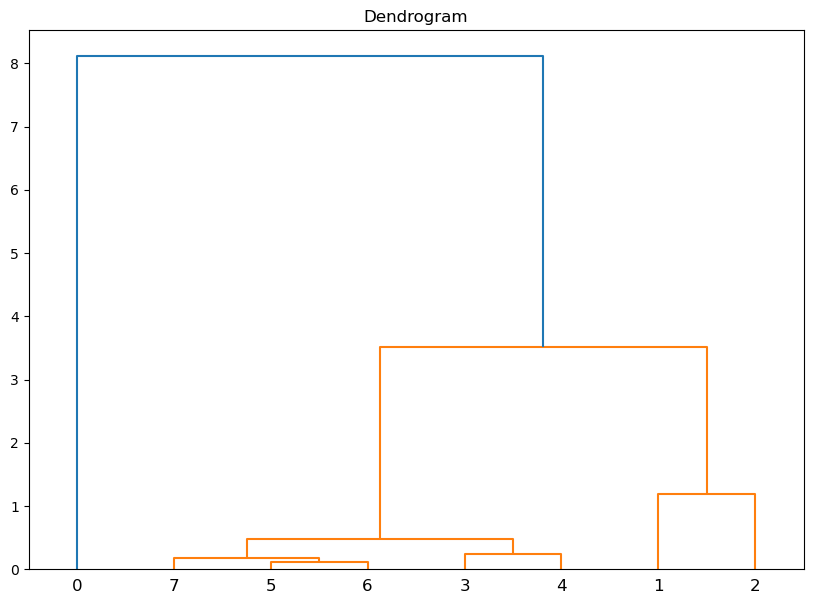

In [4]:
# Perform the clustering
cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(features_scaled)

# Optionally, plot a dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram = sch.dendrogram(sch.linkage(features_scaled, method='ward'))
plt.show()

In [5]:
# Assuming 'features_scaled' is your dataset ready for clustering
import pickle

num_samples = features_scaled.shape[0]
max_clusters = min(num_samples - 1, 10)  # Ensuring we do not attempt too many clusters

for n_clusters in range(2, max_clusters + 1):  # Ensure at least two clusters
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = clusterer.fit_predict(features_scaled)
    
    filename = f"cluster_models/cluster_model_Cluster{n_clusters}"
    with open(filename, "wb") as file:
        pickle.dump(clusterer, file)

    # Calculate and print the silhouette score
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.6850267407567748
For n_clusters = 3 The average silhouette_score is : 0.6466328583749363
For n_clusters = 4 The average silhouette_score is : 0.5220272588427455
For n_clusters = 5 The average silhouette_score is : 0.2665148642292524
For n_clusters = 6 The average silhouette_score is : 0.18016423830813588
For n_clusters = 7 The average silhouette_score is : 0.07816023557199069


In [6]:
# Fit the final model
final_cluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
final_labels = final_cluster.fit_predict(features_scaled)

# Add cluster labels to the original DataFrame
df['Cluster'] = final_labels

# Analyze clusters
for i in range(final_cluster.n_clusters):
    cluster_data = df[df['Cluster'] == i]
    print(f"Cluster {i} Summary:")
    print(cluster_data.describe())

Cluster 0 Summary:
       Revenue 2019(millions)  Revenue 2020(millions)  Revenue 2021(millions)  \
count                2.000000                 2.00000                 2.00000   
mean               377.990000               387.24000               407.56500   
std                231.478476               192.10677               168.59547   
min                214.310000               251.40000               288.35000   
25%                296.150000               319.32000               347.95750   
50%                377.990000               387.24000               407.56500   
75%                459.830000               455.16000               467.17250   
max                541.670000               523.08000               526.78000   

       Revenue 2022(millions)  Revenue 2023(millions)  Cluster  
count                2.000000                2.000000      2.0  
mean               450.090000              820.790000      0.0  
std                229.823846              133.940166   

/Users/muskanmittal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/muskanmittal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/muskanmittal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/muskanmittal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of

/Users/muskanmittal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/muskanmittal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/muskanmittal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/muskanmittal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of

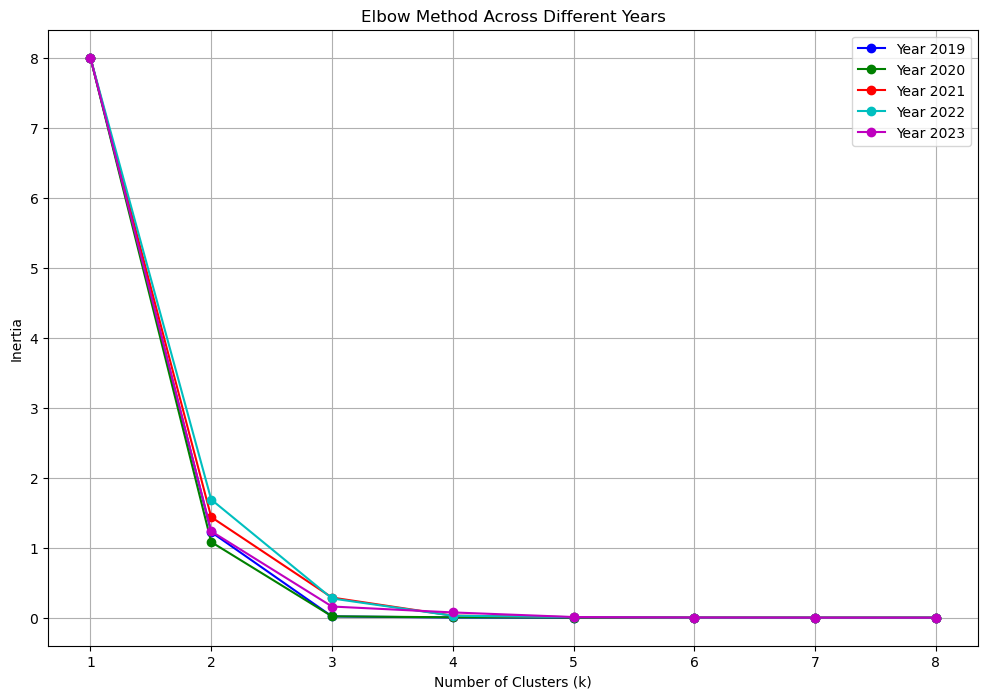

In [10]:
years = ['2019', '2020', '2021', '2022', '2023']
colors = ['b', 'g', 'r', 'c', 'm']  # Define a list of colors for different years

# Ensure data is scaled properly for each year
scaler = StandardScaler()

# Create a figure outside the loop to plot all years on the same graph
plt.figure(figsize=(12, 8))

for year, color in zip(years, colors):
    # Select the column for the current year and drop NA values
    current_year_data = df[f'Revenue {year}(millions)'].dropna().values.reshape(-1, 1)
    if current_year_data.size == 0:
        print(f"No data available for year {year}. Skipping...")
        continue  # Skip this year if there is no data
    
    current_year_data_scaled = scaler.fit_transform(current_year_data)

    # Dynamically adjust the range of k based on the number of samples
    num_samples = len(current_year_data_scaled)
    max_k = min(num_samples, 10)  # Maximum number of clusters is the lesser of num_samples or 10

    inertias = []
    k_values = range(1, max_k + 1)  # Adjust range to ensure k does not exceed number of samples
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(current_year_data_scaled)
        inertias.append(kmeans.inertia_)

    # Plotting the inertia graph for each year on the same plot
    plt.plot(k_values, inertias, marker='o', color=color, label=f'Year {year}')

# Add labels, title, and legend to the plot
plt.title('Elbow Method Across Different Years')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.legend()
plt.grid(True)
plt.show()